In [1]:
#imports
import argparse
import torch
import torch.utils.data
import pickle
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import tables
import torch.nn.modules.upsampling as up

In [2]:
# Training settings
cuda = torch.cuda.is_available()

seed = 10


kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
imagesize ={'x':128,'y':128,'c':3}
n_classes = 10
X_dim = imagesize['x']*imagesize['y']*imagesize['c']
z_dim = 16*16*64
y_dim = 10
train_batch_size = 20
valid_batch_size = 20
N = 5000
epochs = 100 #500

In [3]:
##################################
# Load data and create Data loaders
##################################
def load_data(data_path='../data/'):
    print('loading data!')
    filepath = "data/train_data"
    hdf5_file = tables.open_file(filepath, "r")
    # To access images array:
    trainset_unlabeled = hdf5_file.root.images
    #hdf5_file = tables.open_file(filepath, "r")
    #for i in range(len(trainset_unlabeled)):
    #    plt.imshow(trainset_unlabeled[i])
    #    plt.show()
    #print(len(trainset_unlabeled))
    #print(np.shape(trainset_unlabeled[0]))
    #trainset_unlabeled = pickle.load(open(data_path + "train_unlabeled.p", "rb"))
    # Set -1 as labels for unlabeled data
    trainset_unlabeled.train_labels = hdf5_file.root.labels
    filepath = "data/test_data"
    hdf5_file = tables.open_file(filepath, "r")
    # To access images array:
    validset_unlabeled = hdf5_file.root.images
    trainset_unlabeled.labels = hdf5_file.root.labels
    
    train_unlabeled_loader = torch.utils.data.DataLoader(trainset_unlabeled,
                                                         batch_size=train_batch_size,
                                                         shuffle=True, **kwargs)

    return train_unlabeled_loader,trainset_unlabeled

In [4]:

##################################
# Define Networks
##################################
# Encoder
class Q_net(nn.Module):
    def __init__(self):
        super(Q_net, self).__init__()
        self.channels = [128,64,64]
        self.convkernel = [3]
        self.poolkernel = [2]
        self.conv1 = nn.Conv2d(imagesize['c'],self.channels[0],self.convkernel[0],padding=(1,1))
        self.conv2 = nn.Conv2d(self.channels[0],self.channels[1],self.convkernel[0],padding=(1,1))
        self.conv3 = nn.Conv2d(self.channels[1],self.channels[2],self.convkernel[0],padding=(1,1))
        #self.lin1 = nn.Linear(X_dim, N)
        #self.lin2 = nn.Linear(N, N)
        # Gaussian code (z)
        self.lin3gauss = nn.Linear(self.channels[2]*16*16, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size = self.poolkernel[0])
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size = self.poolkernel[0])
        x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size = self.poolkernel[0])
        x = x.view(train_batch_size,self.channels[2]*16*16)
        xgauss = F.dropout(self.lin3gauss(x), p=0.2, training=self.training)
        return xgauss


In [5]:

# Decoder
class P_net(nn.Module):
    def __init__(self):
        super(P_net, self).__init__()
        self.channels = [128,64,64]
        self.convkernel = [3]
        self.poolkernel = [2]
        self.lin1 = nn.Linear(2, self.channels[2]*16*16)
        self.conv1 = nn.Conv2d(self.channels[2],self.channels[2],self.convkernel[0],padding=(1,1))
        self.ups1 = nn.UpsamplingBilinear2d(scale_factor=self.poolkernel[0])
        self.conv2 = nn.Conv2d(self.channels[2],self.channels[1],self.convkernel[0],padding=(1,1))
        self.ups2 = nn.UpsamplingBilinear2d(scale_factor=self.poolkernel[0])
        self.conv3 = nn.Conv2d(self.channels[1],self.channels[0],self.convkernel[0],padding=(1,1))
        self.ups3 = nn.UpsamplingBilinear2d(scale_factor=self.poolkernel[0])
        self.conv4 = nn.Conv2d(self.channels[0],imagesize['c'],self.convkernel[0],padding=(1,1))
        
    def forward(self, x):
        x = self.lin1(x)
        x = x.view(train_batch_size,self.channels[2],16,16)
        x = self.ups1(F.relu(self.conv1(x)))
        x = self.ups2(F.relu(self.conv2(x)))
        x = self.ups3(F.relu(self.conv3(x)))
        x = self.conv4(x)
        return F.sigmoid(x)

In [6]:

class D_net_gauss(nn.Module):
    def __init__(self):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(2, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)

    def forward(self, x):
        #x = x.view(train_batch_size,z_dim)
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)

        return F.sigmoid(self.lin3(x))

In [7]:

####################
# Utility functions
####################
def save_model(model, filename):
    print('Best model so far, saving it...')
    torch.save(model.state_dict(), filename)


def report_loss(epoch, D_loss_gauss, G_loss, recon_loss,valid_recon_loss):
    '''
    Print loss
    '''
    print('Epoch-{}; D_loss_gauss: {:.4}; G_loss: {:.4}; recon_loss: {:.4}; valid_recon_loss: {:.4}'.format(epoch,
                                                                                   D_loss_gauss.data[0],
                                                                                   G_loss.data[0],
                                                                                   recon_loss.data[0],valid_recon_loss.data[0]))


def create_latent(Q, loader):
    '''
    Creates the latent representation for the samples in loader
    return:
        z_values: numpy array with the latent representations
        labels: the labels corresponding to the latent representations
    '''
    Q.eval()
    labels = []

    for batch_idx, (X, target) in enumerate(loader):

        X = X * 0.3081 + 0.1307
        # X.resize_(loader.batch_size, X_dim)
        X, target = Variable(X), Variable(target)
        labels.extend(target.data.tolist())
        if cuda:
            X, target = X.cuda(), target.cuda()
        # Reconstruction phase
        z_sample = Q(X)
        if batch_idx > 0:
            z_values = np.concatenate((z_values, np.array(z_sample.data.tolist())))
        else:
            z_values = np.array(z_sample.data.tolist())
    labels = np.array(labels)

    return z_values, labels


In [8]:

       
####################
# Train procedure
####################
def train(P, Q, D_gauss, P_decoder, Q_encoder, Q_generator, D_gauss_solver, data_loader,valid_data,update_disc = True):
    '''
    Train procedure for one epoch.
    '''
    TINY = 1e-15
    # Set the networks in train mode (apply dropout when needed)
    Q.train()
    P.train()
    D_gauss.train()

    # Loop through the labeled and unlabeled dataset getting one batch of samples from each
    # The batch size has to be a divisor of the size of the dataset or it will return
    # invalid samples
    last_g_loss = 100
    last_g_grad = 1
    v_size = len(valid_data)
    v_data = np.zeros((v_size,imagesize['c'],imagesize['x'],imagesize['y']))
    for i in range(v_size):
        v_data[i] = np.array(valid_data[i])
    v_data = 1 - v_data/255
    V = Variable(torch.FloatTensor(v_data))#.resize_(valid_batch_size, X_dim)
    if cuda:
            V= V.cuda()
    for X in data_loader:
        # Load batch and normalize samples to be between 0 and 1
        X = 1-X/255
        #X.resize_(train_batch_size, X_dim)
        X= Variable(X)
        X = X.type(torch.FloatTensor)
        if cuda:
            X= X.cuda()

        # Init gradients
        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        #######################
        # Reconstruction phase
        #######################
        z_sample = Q(X)
        X_sample = P(z_sample)
        recon_loss = F.binary_cross_entropy(X_sample + TINY, X + TINY) #.resize(train_batch_size, X_dim)
        recon_loss.backward()
        P_decoder.step()
        Q_encoder.step()

        P.zero_grad()
        Q.zero_grad()
        
        # recon loss for valid set
        z_sample = Q(V)
        X_sample = P(z_sample)
        recon_loss_valid = F.binary_cross_entropy(X_sample + TINY, X + TINY) #.resize(train_batch_size, X_dim)
        P.zero_grad()
        Q.zero_grad()
        
        D_gauss.zero_grad()

        #######################
        # Regularization phase
        #######################
        # Discriminator
        Q.eval()
        z_real_gauss = Variable(torch.randn(train_batch_size, 2) * 5.)
        if cuda:
            z_real_gauss = z_real_gauss.cuda()

        z_fake_gauss = Q(X)
        #print('network',D_gauss)
        #print('fake', np.shape(z_fake_gauss))
        #print('real', np.shape(z_real_gauss))
        D_real_gauss = D_gauss(z_real_gauss)
        D_fake_gauss = D_gauss(z_fake_gauss)
        D_loss = -torch.mean(torch.log(D_real_gauss + TINY) + torch.log(1 - D_fake_gauss + TINY))
        if update_disc:#last_g_loss < D_loss.data[0]: #update_disc:
            #print(last_g_grad,D_loss.data[0])
            #print('updating descriminator')
            D_loss.backward()
            D_gauss_solver.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()

        # Generator
        Q.train()
        z_fake_gauss = Q(X)

        D_fake_gauss = D_gauss(z_fake_gauss)
        G_loss = -torch.mean(torch.log(D_fake_gauss + TINY))
        last_g_grad = last_g_loss - G_loss.data[0]
        last_g_loss = G_loss.data[0]
        G_loss.backward()
        Q_generator.step()

        P.zero_grad()
        Q.zero_grad()
        D_gauss.zero_grad()
    return D_loss, G_loss, recon_loss, recon_loss_valid



In [9]:
def generate_model( train_unlabeled_loader,valid_data):
    torch.manual_seed(10)

    if cuda:
        Q = Q_net().cuda()
        P = P_net().cuda()
        D_gauss = D_net_gauss().cuda()
    else:
        Q = Q_net()
        P = P_net()
        D_gauss = D_net_gauss()

    # Set learning rates
    gen_lr = 0.001
    reg_lr = 0.00005

    # Set optimizators
    P_decoder = optim.Adam(P.parameters(), lr=gen_lr)
    Q_encoder = optim.Adam(Q.parameters(), lr=gen_lr)

    Q_generator = optim.Adam(Q.parameters(), lr=reg_lr)
    D_gauss_solver = optim.Adam(D_gauss.parameters(), lr=reg_lr)
    losses = []
    update_disc = True
    for epoch in range(epochs):
        D_loss_gauss, G_loss, recon_loss,recon_loss_valid = train(P, Q, D_gauss, P_decoder, Q_encoder,
                                                 Q_generator,
                                                 D_gauss_solver,
                                                 train_unlabeled_loader,valid_data,update_disc)
        if epoch % 1 == 0:#chaged here!
            report_loss(epoch, D_loss_gauss, G_loss, recon_loss,recon_loss_valid)
            losses.append((epoch, D_loss_gauss.data[0], G_loss.data[0], recon_loss.data[0],recon_loss_valid.data[0]))
            update_disc = D_loss_gauss.data[0] > G_loss.data[0]
    return Q, P

In [10]:
if __name__ == '__main__':
    train_unlabeled_loader,valid_data = load_data()
    Q, P = generate_model( train_unlabeled_loader,valid_data)

loading data!


/home/minato/.virtualenvs/dlcv/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


Epoch-0; D_loss_gauss: 1.313; G_loss: 0.6819; recon_loss: 0.6921; valid_recon_loss: 0.6627
Epoch-1; D_loss_gauss: 1.471; G_loss: 2.538; recon_loss: 0.6477; valid_recon_loss: 0.6369
Epoch-2; D_loss_gauss: 1.022; G_loss: 1.149; recon_loss: 0.7363; valid_recon_loss: 0.6402
Epoch-3; D_loss_gauss: 0.771; G_loss: 0.9474; recon_loss: 0.6068; valid_recon_loss: 0.6617
Epoch-4; D_loss_gauss: 1.101; G_loss: 0.8964; recon_loss: 0.6478; valid_recon_loss: 0.6684
Epoch-5; D_loss_gauss: 0.8639; G_loss: 1.114; recon_loss: 0.6601; valid_recon_loss: 0.6696
Epoch-6; D_loss_gauss: 1.122; G_loss: 1.028; recon_loss: 0.6637; valid_recon_loss: 0.6682
Epoch-7; D_loss_gauss: 0.7385; G_loss: 1.604; recon_loss: 0.662; valid_recon_loss: 0.6625
Epoch-8; D_loss_gauss: 0.7221; G_loss: 1.695; recon_loss: 0.6498; valid_recon_loss: 0.6512
Epoch-9; D_loss_gauss: 0.8861; G_loss: 3.351; recon_loss: 0.6373; valid_recon_loss: 0.6314
Epoch-10; D_loss_gauss: 0.4095; G_loss: 4.084; recon_loss: 0.5949; valid_recon_loss: 0.5767
Ep

Epoch-91; D_loss_gauss: 1.058; G_loss: 1.112; recon_loss: 0.325; valid_recon_loss: 0.5565
Epoch-92; D_loss_gauss: 1.22; G_loss: 0.9451; recon_loss: 0.3154; valid_recon_loss: 0.5702
Epoch-93; D_loss_gauss: 1.056; G_loss: 0.7734; recon_loss: 0.3026; valid_recon_loss: 0.5334
Epoch-94; D_loss_gauss: 0.7652; G_loss: 0.8944; recon_loss: 0.2959; valid_recon_loss: 0.5109
Epoch-95; D_loss_gauss: 0.6851; G_loss: 0.8854; recon_loss: 0.3088; valid_recon_loss: 0.5983
Epoch-96; D_loss_gauss: 0.9953; G_loss: 0.9258; recon_loss: 0.3103; valid_recon_loss: 0.5926
Epoch-97; D_loss_gauss: 0.9924; G_loss: 0.7896; recon_loss: 0.3646; valid_recon_loss: 0.5208
Epoch-98; D_loss_gauss: 0.8122; G_loss: 0.8465; recon_loss: 0.2877; valid_recon_loss: 0.5581
Epoch-99; D_loss_gauss: 0.7324; G_loss: 0.8535; recon_loss: 0.2981; valid_recon_loss: 0.5753


In [11]:
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
import math

def hardcodedTransform(array):
    return (1-array/255)

def transformForNetwork(array):
    return Variable(torch.FloatTensor( hardcodedTransform(array))).cuda()

def showarray(a,do = False, fmt='png'):
    #a = np.uint8(hardcodedTransform(a)*256)
    f = BytesIO()
    if imagesize['c'] == 1:
        PIL.Image.fromarray(a.reshape(imagesize['x'],imagesize['y'])).save(f, fmt)
        IPython.display.display(IPython.display.Image(data=f.getvalue()))
    if imagesize['c'] == 3:
        a = np.reshape(a,(imagesize['c'],imagesize['x'],imagesize['y']))
        a = np.transpose(a,(1,2,0))
        plt.imshow(a)
        plt.show()

loading data!


/home/minato/.virtualenvs/dlcv/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


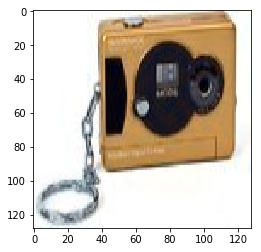

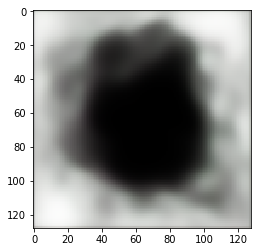

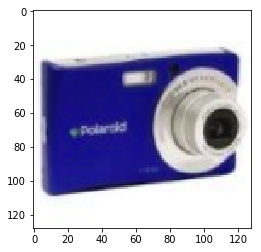

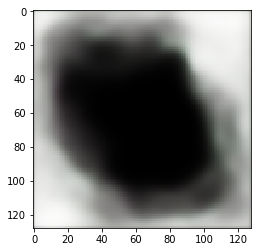

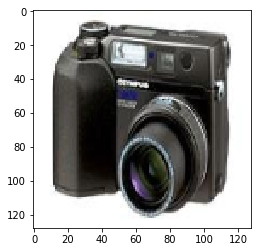

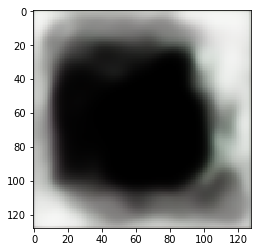

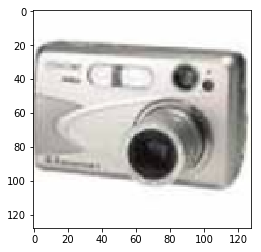

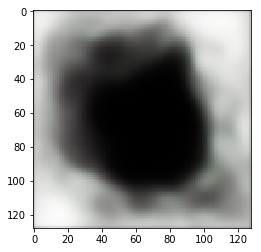

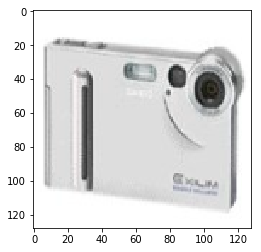

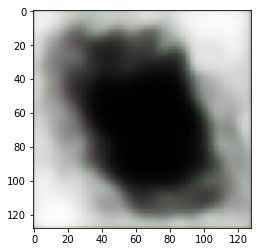

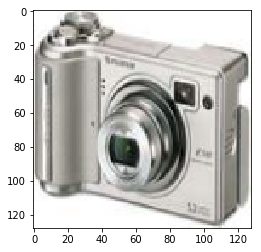

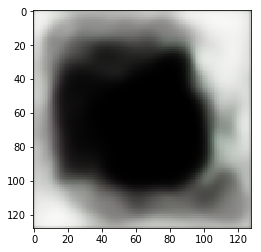

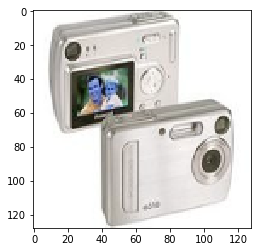

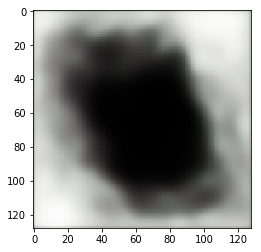

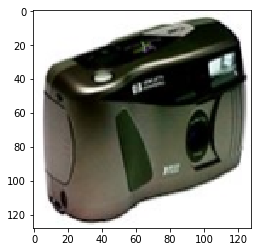

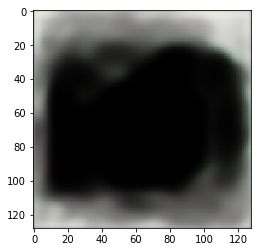

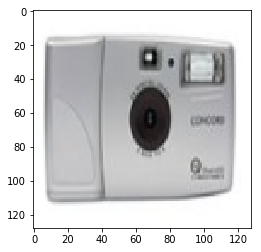

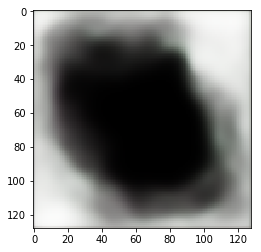

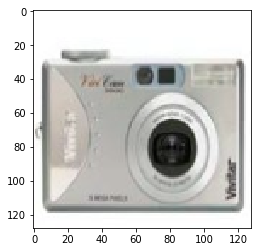

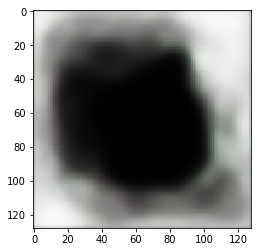

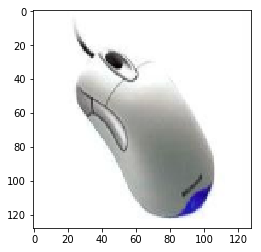

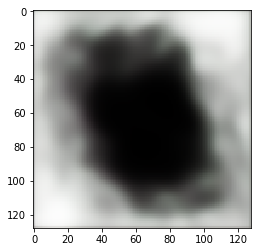

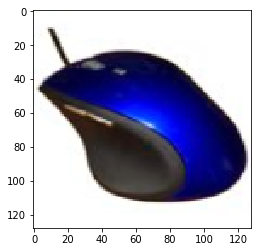

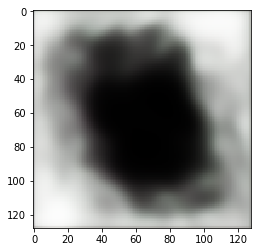

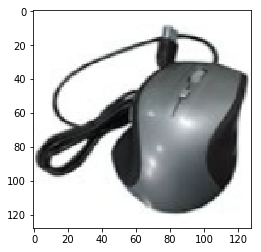

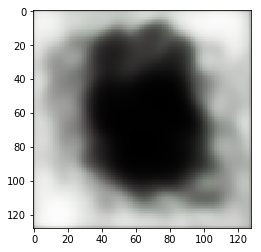

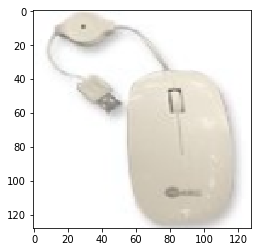

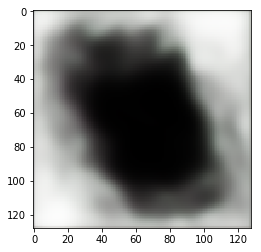

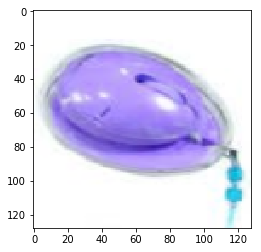

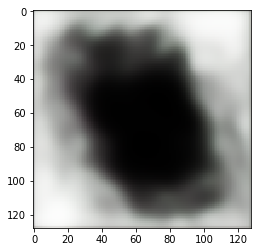

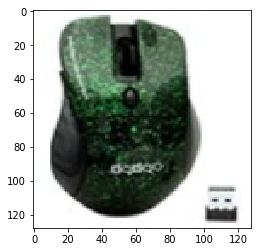

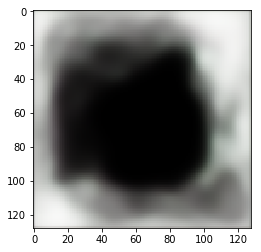

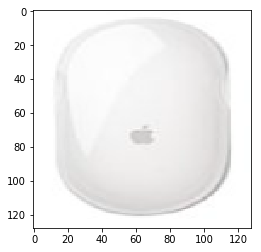

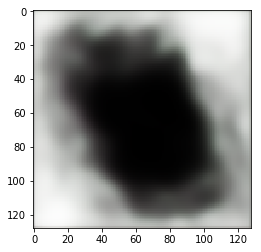

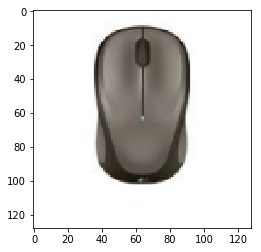

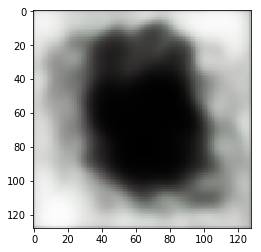

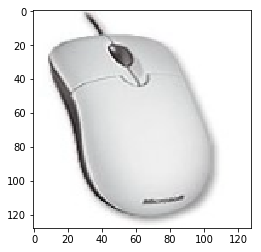

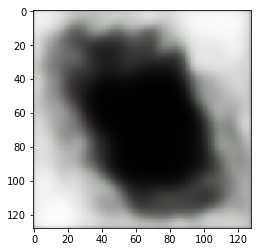

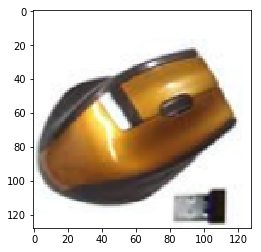

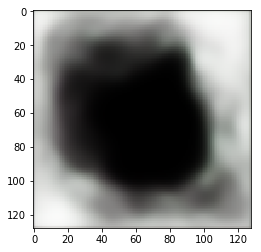

In [13]:
from PIL import Image
from IPython.display import Image, display

TINY = 1e-15
train_batch_size = 1

my_loader = load_data()

i = 0
max_images = 20
out = []
imgList = np.zeros((max_images,imagesize['c'],imagesize['x'],imagesize['y']))
reconimgList = np.zeros((max_images,imagesize['c'],imagesize['x'],imagesize['y']))
imgZValue = np.zeros((max_images,1,2))
filepath = "data/train_data"
hdf5_file = tables.open_file(filepath, "r")
# To access images array:
trainset_unlabeled = hdf5_file.root.images
batches = np.split(trainset_unlabeled, len(trainset_unlabeled)/train_batch_size)
for  X in batches:
    if i>=max_images:
        break
    out = X
    imgList[i] = out[0]
    t = Q(transformForNetwork(out))
    imgZValue[i] = t.cpu().data.numpy()
    reconimg =  P(t)
    reconimgList[i] = reconimg.cpu().data.numpy()
    showarray(out)
    showarray(1-(reconimgList[i]))
    i+=1

In [ ]:
showarray(imgList[0])

In [ ]:
diff_matrix = np.zeros((max_images,max_images))
for i in range(0,max_images):
    for j in range(0,max_images):
        #print(diff_matrix[i,j])
        diff_matrix[i,j]=math.sqrt(sum(np.power(imgZValue[i] - imgZValue[j],2)))
        #print(imgZValue[i] - imgZValue[j])
#print(diff_matrix)
plt.scatter(imgZValue[:,0],imgZValue[:,1])
plt.show()